<a href="https://colab.research.google.com/github/smannan/LIFXBulbAnalysis/blob/main/SmartBulbDataExploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Analyze brightness for Influx light bulbs

1.   Input data frame should have 3 columns: bulb id, timestamp, and value
2.   Supported values are power or brighness
3.   Brightness value should be a floating point
4.   Power should be ON or OFF



In [142]:
import matplotlib.pyplot as plt
import os
import pandas as pd

from datetime import datetime
from dateutil.parser import parse

In [118]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as dates

def plot_hist(bulb_df):
  fig, ax = plt.subplots(figsize=(10, 5))
  ax.hist(bulb_df['value'], bins=25)
  plt.show()

In [120]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [483]:
def drop_seconds_from_timestamp(df):
  current_timezone = pytz.timezone("US/Pacific")
  bulb_data['timestamp'] = pd.to_datetime(bulb_data['timestamp'])
  bulb_data['timestamp'] = bulb_data['timestamp'].dt.strftime('%Y-%m-%d %H:%M')
  bulb_data['timestamp'] = pd.to_datetime(bulb_data['timestamp'])

In [484]:
filename = '/content/drive/Shared drives/CMPE295B/ProcessedBulbData/smart_bulb_brightness_data_from_influx_aug27_sept9.csv'
bulb_data = pd.read_csv(filename, infer_datetime_format = True)
drop_seconds_from_timestamp(bulb_data)
bulb_data.drop(['Unnamed: 0'], axis=1, inplace=True)

In [485]:
bulb_data.head()

,timestamp,value,id
0,2021-08-27 02:34:00,0.607,d073d55df12f
1,2021-08-27 02:35:00,0.607,d073d55df12f
2,2021-08-27 02:36:00,0.607,d073d55df12f
3,2021-08-27 02:37:00,0.607,d073d55df12f
4,2021-08-27 02:38:00,0.607,d073d55df12f


In [346]:
bulb_data['value'].describe()

count    5208.000000
mean        0.856206
std         0.076649
min         0.000000
25%         0.833700
50%         0.833700
75%         0.833700
max         0.993100
Name: value, dtype: float64

In [347]:
# group by light bulb id and sum the number of nulls in the value column
# AKA the number of missing readings for each bulb
# 77.8% missing values for bulb d073d55df12f
# 61.1% missing values for bulb d073d55e535c
bulb_data.groupby(['id']).agg({ 'value': lambda x: x.isnull().sum() })

,value
id,
d073d55df12f,0.0
d073d55e535c,0.0


In [392]:
def analyze_df_for_bulb(bulb_df):
  print('start time', bulb_df['timestamp'].min(), 'end time', bulb_df['timestamp'].max())

  # fill in missing values with 0 (off)
  if (bulb_data['value'].isnull().sum()):
    bulb_df['value'] = bulb_df['value'].fillna(0)
  
  plt.plot(bulb_df['timestamp'], bulb_df['value'])
  plt.gcf().autofmt_xdate()

  find_time_interval_gaps(bulb_df)

In [447]:
def find_time_interval_gaps(bulb_df, interval=1.0):
  times = bulb_df['timestamp'].tolist()
  start_time = times[0]
  diffs = []

  for timestamp in times:
    diff_in_minutes = (timestamp - start_time).total_seconds() / 60

    if (diff_in_minutes > interval):
      diffs.append(diff_in_minutes)

    start_time = timestamp

  if (diffs):
    print ('# of intervals > 1 min = {0}. Max diff = {1}, Min diff = {2}, Avg diff = {3}'.format(
      len(diffs), max(diffs), min(diffs), sum(diffs) / len(diffs)))
  
  return diffs

start time 2021-08-27 02:34:00 end time 2021-09-09 05:54:00
# of intervals > 1 min = 9. Max diff = 7034.0, Min diff = 116.0, Avg diff = 1791.2222222222222


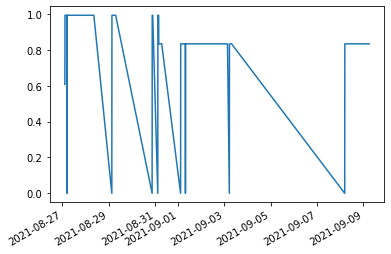

In [386]:
analyze_df_for_bulb(bulb_data.loc[bulb_data['id'] == 'd073d55df12f'])

In [425]:
def fill_in_missing_times(bulb_data, id):
  light_df = bulb_data.loc[bulb_data['id'] == id]
  r = pd.date_range(start=light_df.timestamp.min(), end=light_df.timestamp.max(), freq='1min')
  reindexed = light_df.set_index('timestamp').reindex(r).rename_axis('timestamp').reset_index()
  reindexed['value'].fillna(0, inplace=True)
  reindexed['id'].fillna(id, inplace=True)
  return reindexed

In [433]:
light_df = fill_in_missing_times(bulb_data, 'd073d55df12f')
light_df.head()

,timestamp,value,id
0,2021-08-27 02:34:00,0.607,d073d55df12f
1,2021-08-27 02:35:00,0.607,d073d55df12f
2,2021-08-27 02:36:00,0.607,d073d55df12f
3,2021-08-27 02:37:00,0.607,d073d55df12f
4,2021-08-27 02:38:00,0.607,d073d55df12f


start time 2021-08-27 02:34:00 end time 2021-09-09 05:54:00


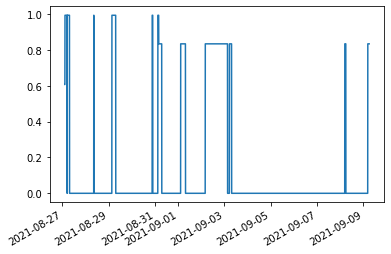

In [434]:
analyze_df_for_bulb(light_df)

In [435]:
def range_brightness(brightness):
  if brightness <= 0.5:
    return 0
  else:
    return 1

In [436]:
def brightness_to_category(df):
  df['value'] = df['value'].apply(lambda value: range_brightness(value))

In [439]:
brightness_to_category(light_df)

In [466]:
from pytz import timezone
import pytz
import datetime

### Plot intervals usage based on state change in the bulb (ON to OFF or vice versa)
def get_power_intervals(bulb_df):
  intervals = []
  cycle = bulb_df['value'][0]
  start = bulb_df['timestamp'][0]
  current_timezone = pytz.timezone("US/Pacific")

  for value, timestamp in zip(bulb_df['value'][1:], bulb_df['timestamp'][1:]):
    if value != cycle:
      duration = timestamp - start
      duration = round(duration.total_seconds() / 60 / 60, 2)

      intervals.append({ 'start': current_timezone.localize(start).strftime('%m/%d/%Y %H:%M:%S %Z'),
                         'end': current_timezone.localize(timestamp).strftime('%m/%d/%Y %H:%M:%S %Z'),
                         'from': cycle,
                         'to': value,
                         'duration (hours)': duration})
      cycle = value
      start = timestamp

  df = pd.DataFrame(intervals)
  return df

In [467]:
interval_df = get_power_intervals(light_df)

In [468]:
on_times = interval_df.loc[interval_df['from'] == 1]
on_times

,start,end,from,to,duration (hours)
0,08/27/2021 02:34:00 PDT,08/27/2021 05:02:00 PDT,1,0,2.47
2,08/27/2021 05:03:00 PDT,08/27/2021 07:25:00 PDT,1,0,2.37
4,08/28/2021 08:31:00 PDT,08/28/2021 08:41:00 PDT,1,0,0.17
6,08/29/2021 03:18:00 PDT,08/29/2021 07:17:00 PDT,1,0,3.98
8,08/30/2021 21:03:00 PDT,08/30/2021 21:40:00 PDT,1,0,0.62
10,08/31/2021 02:55:00 PDT,08/31/2021 06:58:00 PDT,1,0,4.05
12,09/01/2021 02:33:00 PDT,09/01/2021 07:33:00 PDT,1,0,5.00
14,09/01/2021 07:34:00 PDT,09/01/2021 07:35:00 PDT,1,0,0.02
16,09/02/2021 04:02:00 PDT,09/03/2021 03:08:00 PDT,1,0,23.10
18,09/03/2021 05:04:00 PDT,09/03/2021 07:21:00 PDT,1,0,2.28


In [465]:
off_times = interval_df.loc[interval_df['from'] == 0]
off_times

,start,end,from,to,duration (hours)
1,08/27/2021 05:02:00,08/27/2021 05:03:00,0,1,0.02
3,08/27/2021 07:25:00,08/28/2021 08:31:00,0,1,25.10
5,08/28/2021 08:41:00,08/29/2021 03:18:00,0,1,18.62
7,08/29/2021 07:17:00,08/30/2021 21:03:00,0,1,37.77
9,08/30/2021 21:40:00,08/31/2021 02:55:00,0,1,5.25
11,08/31/2021 06:58:00,09/01/2021 02:33:00,0,1,19.58
13,09/01/2021 07:33:00,09/01/2021 07:34:00,0,1,0.02
15,09/01/2021 07:35:00,09/02/2021 04:02:00,0,1,20.45
17,09/03/2021 03:08:00,09/03/2021 05:04:00,0,1,1.93
19,09/03/2021 07:21:00,09/08/2021 04:35:00,0,1,117.23


### Pre-processing
1. Any brightness > 0.5 is considered ON
2. Multiple missing time gaps - these were filled with a value of OFF
3. Original dataset did not have any missing values
4. Original length ~2.8k, after processing ~19k

### Results
1. Lights were on from Sept 2nd to Sept 3rd?
2. Lights were off from Sept 3rd to Sept 8th (participants came home on the 6th)
3. Lights were also off for most of the day on Sept 8th to 9th